In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.nn.init as init
from torch.distributions import Categorical
import numpy as np
from tqdm.notebook import tqdm, trange
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
import seaborn as sns

from model.CustomDataSet import CustomDataSetRNN, SimpleDataSet
from model.Tokenizer import SimpleTokenizerV1
from model.TokenDrop import TokenDrop, TokenDropOdd, TokenDropEven
from model.RNN import LSTM_representation, LSTM_GenText
from environnement.gridWorld import gridWorld
from outil import *
from inter.simpleInteraction import simpleInteraction as inter

In [2]:
device = "cpu" if not torch.cuda.is_available() else "cuda"
# device = "cpu" # Pour forcer l'utilisation du CPU
print("Using device:", device)

CONTEXT_LENGTH = 50     

Using device: cuda


In [3]:
class CustomDataSetInfo(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info
    
class DecoupSeqToDataSet(Dataset):
    def __init__(self, seq, seq_len):
        """
        Découpe une séquence en un dataset de séquences de longueur seq_len.
        """
        assert len(seq) >= seq_len, "La séquence doit être plus longue que la longueur de la séquence"
        assert seq_len % 2 == 0, "La longueur des séquences voulut doit être paire"
        self.seq = seq
        self.seq_len = seq_len
        self.data = []
        self.create_data()
        
    def create_data(self):
        for i in range(0, len(self.seq) - self.seq_len + 1, self.seq_len):
            self.data.append(self.seq[i:i+self.seq_len])
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx])

In [4]:
def train_fb(model:LSTM_representation, data_loader_train: DataLoader, nb_epoch: int, optimizer, loss_fn, td_fb:TokenDrop):
    model.train()
    list_acc = []
    list_loss = []
    for j in range(nb_epoch):
        acc_means = 0
        loss_means = 0
        
        for i, data in enumerate(data_loader_train):
            data = data.to(device)
            data_mask_fb = td_fb(data).to(device)
            bs = data.shape[0]
            # for k in range(bs):
            #     print(f"x[{k}] : {data_mask_fb[k]}")
            #     print(f"y[{k}] : {data[k]}")
            
            # print("batch size ", bs)

            # Initialize the memory buffers
            hidden = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            memory = torch.zeros(2 * model.num_layers, bs, model.hidden_size, device=device)
            # print(f'shape hidden and memory {hidden.shape} | {memory.shape}')
                        
            proba, hidden, memory = model(data_mask_fb, hidden, memory)
            proba = proba.transpose(1, 2)
            pred = proba.argmax(dim=1)
            pad_mask = (data_mask_fb == 0)
 
            correct = (pred == data) & pad_mask
            acc = correct.sum().item() / pad_mask.sum().item() if pad_mask.sum().item() > 0 else 0.0
            acc_means += acc
        
            loss = loss_fn(proba, data) 
            loss_means += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc_means /= len(data_loader_train)
        loss_means /= len(data_loader_train)
        list_acc.append(acc_means)
        list_loss.append(loss_means)
        # tqdm.write(f"Epoch {j + 1}/{nb_epoch}, Loss: {loss_means}, Accuracy: {acc_means}")
    return list_acc, list_loss

In [5]:
class AgentLSTMrepresentation:
    def __init__(self, valence:dict[inter], model:nn.Module, maxDepth:int, tokenizer:SimpleTokenizerV1,
                seuil:float, optimizer, loss_fn, gap:int=11, nb_epochs:int=50, dataloader:object = DataLoader,
                explo:int=3, pourcentDrop:int=0.25, data_val:tuple=None, device="cpu"):
        """
        Parameters
        ----------
        valence : dict[inter]
            dictionnaire de la forme {inter:valence} où inter est une interaction et valence sa valeur
        model : nn.Module
            le modèle de réseau de neurones à utiliser
        maxDepth : int
            profondeur maximale de l'arbre de recherche
        seuil : float
            seuil de convergence
        optimizer : torch.optim.Optimizer
            l'optimiseur à utiliser pour la descente de gradient
        loss_fn : callable
            la fonction de perte à utiliser pour l'entraînement
        gap : int
            le nombre d'itérations entre chaque mise à jour du modèle
        nb_epochs : int
            le nombre d'époques d'entraînement
        explo : int
            le nombre d'itérations d'exploration
        data_val : tuple
            les données de validation sous la forme (X, y) où X est un tableau de caractéristiques et y est un tableau d'étiquettes
        device : str
            le périphérique sur lequel exécuter le modèle (CPU ou GPU)
        """
        self.model:LSTM_representation = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.valence:dict[inter] = valence
        self.maxDepth:int = maxDepth
        self.seuil:float = seuil
        self.gap:int = gap
        self.nbEpochs:int = nb_epochs
        self.force_fit:bool = False
        
        self.device = device
        self.last_train = 0
        self.proba = 0
        self.explo = explo
        
        self.dl:object = dataloader
        
        self.seq_to_exe = [] # Sequence choice by Decide
        self.compute_seq = {}
        self.history_act = [] # History of all actions
        self.history_fb = [] # History of all feedback
        self.history_inter = [] # History of all interactions
        
        self.all_outcomes = set()
        self.all_act = set()
        key:inter = None
        for key in valence.keys():
            self.all_outcomes.add(key.getOutcome())
            self.all_act.add(key.getAction())
            
        self.all_outcomes = list(self.all_outcomes)
        self.all_act = list(self.all_act)
        
        self.tokenizer = tokenizer
        
        self.td:TokenDrop = TokenDropOdd(num_special=0,
                                        pad_token=self.tokenizer.encode("<pad>"),
                                        prob=pourcentDrop)
        
        self.seq_explo = []
        self.valence_explo = -np.inf
        
        self.action_choice = self.all_act[0] # Default action, because developpemental start with action
        self.history_act.append(str(self.action_choice))
        self.outcome_prediction = None
        
        self.memory = {}
        
        # Variable to monitor the model
        self.loss_train:list = []
        self.acc_train:list = []
        self.loss_test:list = [0]
        self.acc_test:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.time_train:list = []
        self.time_expected_val:list = []
        self.predictExplor:list = []
        self.last_fit = 0
        
    def fit(self, troncature:int=1000):
        data_train = []
        if troncature > 1:
            data_train = self.history_inter[-troncature:]
        else:
            data_train = self.history_inter
        data_set = self.dl(data_train, self.gap)
        # taille du jeu de donnée
        data_loader = DataLoader(data_set, batch_size=16, shuffle=True)
        # for i, data in enumerate(data_loader):
        #     print(f"batch {i} / :")
        #     for j in range(data.shape[0]):
        #         print(f"data {j} : {data[j]}")
        
        acc, _ = train_fb(
            model=self.model,
            data_loader_train=data_loader, 
            nb_epoch=self.nbEpochs,
            optimizer=self.optimizer,
            loss_fn=self.loss_fn,
            td_fb=self.td)
        return acc[-1]
        
    def predict(self, action):
        """
        Predict the feedback of the action, use the last gap actions/outcomes
        """        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        x.append(action)
        x.append("<pad>")
        seq_to_pred = self.tokenizer.encode(x)
        # On simule un batch de taille 1
        seq_to_pred = torch.tensor([seq_to_pred], device=self.device)
        hidden = torch.zeros(2 * self.model.num_layers, 1, self.model.hidden_size).to(device)
        memory = torch.zeros(2 * self.model.num_layers, 1, self.model.hidden_size).to(device)
        probs, _, _ = self.model(seq_to_pred, hidden, memory)
        
        pred_feedback = torch.argmax(probs[:, -1, :]).item()
        pred_feedback = self.tokenizer.decode(pred_feedback)
        
        return pred_feedback     
    
    def verify_explo(self, seq_to_pred, action, max_depth:int, previous_proba:float):
        # print("history_inter :", self.history_inter)
        sub_list = subfinder(self.history_inter, seq_to_pred[-self.explo:])        
        dict_explo = None
        if sub_list == []:
            # print("sub_list is empty, explo !", seq_to_pred[-self.explo:])
            inter_with_act = [inter(action, out) for out in self.all_outcomes]
            best_inter_act = None
            tmp_valence = -np.inf
            for tmp_inter in inter_with_act:
                if self.valence[tmp_inter] > tmp_valence:
                    best_inter_act = tmp_inter
                    tmp_valence = self.valence[tmp_inter]
            proba = []
            dict_explo = {
                "action" : action,
                "expected_valence" : tmp_valence,
                "outcome" : {"proba": None},
            }
            for out in self.all_outcomes:
                if out == best_inter_act.getOutcome():
                    proba.append((1, out))
                    if max_depth > 0:
                        new_context = seq_to_pred + self.tokenizer.encode([action, out])
                        children = self.recursif_expective_valance(context=new_context[2:], max_depth=max_depth, seuil=self.seuil, previous_proba=previous_proba)
                    
                        best_child = max(children, key=lambda x: x["expected_valence"])
                        dict_explo["outcome"] [out] =  best_child
                        dict_explo["expected_valence"] += best_child["expected_valence"]
                    else:
                        dict_explo["outcome"] [out] = {}
                else:
                    proba.append((-1, out))
                    dict_explo["outcome"] [out] = {}
                    
            dict_explo["outcome"] ["proba"] = proba
            
        return dict_explo
    
    def recursif_expective_valance(self, context:list, max_depth:int, seuil:float=0.5, previous_proba:float = 1):
        """
        Create the tree of proposed sequences
        """
        max_depth -= 1
        self.model.eval()
        # Compute the expected valence of each action
        list_action = []
        for act in self.all_act:
            dict_seq = {"action" : act,"expected_valence" :0,}
            seq_to_predict = context + [self.tokenizer.encode(act)]
            # print("seq_to_predict :", seq_to_predict)
            explo = self.verify_explo(seq_to_predict, act, max_depth, previous_proba)
            if explo is not None:
                list_action.append(explo)
                continue
            seq_to_predict.append(self.tokenizer.encode("<pad>"))
            seq_to_predict = torch.tensor([seq_to_predict], dtype=torch.int).to(device)
            bs = 1
            hidden = torch.zeros(2 * self.model.num_layers, bs, self.model.hidden_size).to(device)
            memory = torch.zeros(2 * self.model.num_layers, bs, self.model.hidden_size).to(device)
            x, _, _ = self.model(seq_to_predict, hidden, memory)
            probs = torch.nn.functional.softmax(x[0, -1, :], dim=0).tolist()
            if probs[self.tokenizer.encode("empty")] + probs[self.tokenizer.encode("wall")] < 0.9:
                print("proba is not good :", probs)
                print(seq_to_predict)
                print(self.tokenizer.decode(seq_to_predict.tolist()[0]))
            # Display the probabilities
            # print("seq_to_predict :", seq_to_predict)
            # for out in self.all_outcomes:
            #     print(f"Action: {act}, Outcome: {out}, Probability: {probs[self.tokenizer.encode(out)]}")
            # print(probs)
            # if len(self.history_act) > 20:
            #     input(f"Press Enter to continue...")
            proba = []
            dict_seq["outcome"] = {}
            for i, out in enumerate(self.all_outcomes):
                tmp_proba = probs[self.tokenizer.encode(out)] * previous_proba
                proba.append((probs[self.tokenizer.encode(out)], out))
                
                if tmp_proba > seuil:
                    if max_depth > 0:
                        new_context = context + self.tokenizer.encode([act, out])
                        children = self.recursif_expective_valance(context=new_context[2:], 
                                                                max_depth=max_depth, 
                                                                seuil=seuil,
                                                                previous_proba=tmp_proba)
                    
                        best_child = max(children, key=lambda x: x["expected_valence"])
                        dict_seq["outcome"] [out] =  best_child
                        dict_seq["expected_valence"] += best_child["expected_valence"] * probs[self.tokenizer.encode(out)] + self.valence[inter(act, out)] * probs[self.tokenizer.encode(out)]
                    else:
                        dict_seq["outcome"] [out] = {}
                        dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[self.tokenizer.encode(out)]
                else:
                    dict_seq["outcome"] [out] = {}
                    dict_seq["expected_valence"] += self.valence[inter(act, out)] * probs[self.tokenizer.encode(out)]
            dict_seq["outcome"] ["proba"] = proba
            list_action.append(dict_seq)
                   
        return list_action
    
    def expective_valance(self):
        """
        Permet de calculer l'expective valance d'une séquence d'interaction

        Args:
            max_depth (int): _description_
            seuil (float, optional): _description_. Defaults to 0.2.
            verbose (bool, optional): _description_. Defaults to False.
        """
        
        x = []
        for i in range(-(self.gap - 1) // 2, 0, 1):
            x.append(self.history_act[i])
            x.append(self.history_fb[i])
        # print("x :", x)
        seq_to_pred = self.tokenizer.encode(x)
        if str(x) in self.memory.keys():
            if self.memory[str(x)] ["iteraction_update"] >= self.last_fit:
                self.compute_seq = self.memory[str(x)] ["prealloc_df"]
                return
    
        tmp = self.recursif_expective_valance(context=seq_to_pred, max_depth=self.maxDepth, previous_proba=1, seuil=self.seuil)
        self.compute_seq = max(tmp, key=lambda x: x["expected_valence"])
        self.memory[str(x)] = {
            "prealloc_df" : self.compute_seq,
            "iteraction_update" : len(self.history_act)
        }
        
    def decide(self):
        """
        Permet de choisir une action en fonction de l'expective valance prédite
        """
        print(self.compute_seq)
        if self.compute_seq != {}:
            # print("i follow : \n", self.compute_seq)
            self.compute_seq = self.compute_seq[self.history_fb[-1]]
            if self.compute_seq == {}:
                # self.force_fit = True
                time_compute_expective_val = time.time()
                self.expective_valance()
                print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
                self.time_expected_val.append(time.time() - time_compute_expective_val)
            else :
                print("act choice")
        else :
            time_compute_expective_val = time.time()
            self.expective_valance()
            print(f"Time to compute expective valance: {time.time() - time_compute_expective_val}")
            self.time_expected_val.append(time.time() - time_compute_expective_val)

        if self.compute_seq == []:
            print("i have no compute seq")
        print(f"expected valence : {self.compute_seq['expected_valence']:.2f} model predict : {self.compute_seq}")
        action = self.compute_seq["action"]
        self.proba = max(self.compute_seq["outcome"]["proba"])[0]
        # print(f"proba : {self.proba}")
        # print(f"action : {action}")
        # print(self.compute_seq)
        # input(f"Press Enter to continue...")

        self.compute_seq = self.compute_seq["outcome"]
        return action
    
    def action(self, real_outcome, verbose=False):
        """
        La fonction action permet à l'agent de choisir une action en fonction de l'outcome réel.
        Cette fonction entraine le modèle a prévoir les outcomes futurs en fonction des actions passées.

        Args:
            real_outcome : L'outcome réel suite à l'action de l'agent
            verbose : Affiche les informations sur l'entrainement ou non
        """
        # La première étape est de sauvegarder l'outcome réel
        self.history_fb.append(real_outcome)
        self.history_inter.append(self.tokenizer.encode(real_outcome))
        good_pred:bool = self.outcome_prediction == real_outcome
        if verbose :
            print(f"Iteration {len(self.history_act)} \033[0;31m Action: {self.action_choice} \033[0m, Prediction: {self.outcome_prediction}, Outcome: {real_outcome}, \033[0;31m Satisfaction: {good_pred} \033[0m")
        
        # Ensuite nous regardons si nous devons entrainer le modèle
        # not(explore) and 
        if (not(good_pred) or self.force_fit) and (len(self.history_fb) + len(self.history_fb) > self.gap) and (self.proba > 0.6 or self.proba < 0.4):
            print("fit because probability is ", self.proba)
            self.fit()
            self.last_fit = len(self.history_act)
            self.force_fit = False
            
        # elif len(self.history_fb) + len(self.history_fb) > self.gap:
        #     for _ in range(self.nbEpochs):
        #         # self.acc_train.append(self.acc_train[-1])
        #         if self.data_loader_test is not None:
        #             self.loss_test.append(self.loss_test[-1])

        # Nous devons maintenant choisir une action
        if len(self.history_fb) + len(self.history_fb) > self.gap:
            self.action_choice = self.decide()
            self.outcome_prediction = self.predict(self.action_choice)
        else:
            inter_max, value = max(self.valence.items(), key=lambda y: y[1])
            self.action_choice = inter_max.getAction()
        # self.action_choice = np.random.choice(self.all_act)
        self.history_act.append(str(self.action_choice))
        self.history_inter.append(self.tokenizer.encode(self.action_choice))
        
        return self.action_choice, self.outcome_prediction
    
    

In [6]:
environnement = gridWorld(x=1, y=1, theta=0, world=np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

valence = {
    inter('forward', 'empty') : 50,
    inter('forward', 'wall') : -200,
    inter('turn_left', 'empty') : -35,
    inter('turn_left', 'wall') : -100,
    inter('turn_right', 'empty') : -35,
    inter('turn_right', 'wall') : -100,
    inter('feel_front', 'wall') : -20,
    inter('feel_front', 'empty') : -20,
    inter('feel_right', 'wall') : -20,
    inter('feel_right', 'empty') : -20,
    inter('feel_left', 'wall') : -20,
    inter('feel_left', 'empty') : -20   
}

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]


In [7]:
list_vocab = []
for fb in environnement.get_outcomes():
    list_vocab.append(fb) 
for act in environnement.get_actions():
    list_vocab.append(act)
list_vocab.append("<pad>")
tmp = create_dico_numerate_word(list_vocab)
tokenizer = SimpleTokenizerV1(vocab=tmp)

In [8]:
seq_tmp = \
['turn_left', 'empty', 'turn_left', 'empty',
 'turn_left', 'empty', 'feel_front', 'wall', 
 'feel_right', 'empty', 'turn_right', 'empty',
 'feel_left', 'wall', 'forward', 'empty',
 'turn_left', 'empty', 'turn_left', 'empty',
 'feel_left', 'wall', 'feel_front', 'empty',
 'feel_front', 'empty', 'forward', 'empty',
 'turn_left', 'empty', 'feel_left', 'empty',
 'turn_left', 'empty', 'turn_left', 'empty',
 'feel_right', 'empty', 'feel_front', 'empty']

seq_tmp = tokenizer.encode(seq_tmp)
ds = DecoupSeqToDataSet(seq_tmp, 6)
for i in range(len(ds)):
    print(ds[i])
dl = DataLoader(ds, batch_size=16, shuffle=True)

del ds, dl, seq_tmp


tensor([3, 1, 3, 1, 3, 1])
tensor([5, 0, 7, 1, 4, 1])
tensor([6, 0, 2, 1, 3, 1])
tensor([3, 1, 6, 0, 5, 1])
tensor([5, 1, 2, 1, 3, 1])
tensor([6, 1, 3, 1, 3, 1])


In [9]:
num_layers = 2
hidden_size = 256
model_fb = LSTM_representation(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0
).to(device)

optimizer_fb = optim.Adam(model_fb.parameters(), lr=0.001)
loss_fn_fb = nn.CrossEntropyLoss()

In [10]:
agent = AgentLSTMrepresentation(
    valence=valence,
    model=model_fb,
    maxDepth=6,
    seuil=0.5,
    optimizer=optimizer_fb,
    loss_fn=loss_fn_fb,
    gap=CONTEXT_LENGTH,
    nb_epochs=40,
    dataloader=DecoupSeqToDataSet,
    explo=1,
    pourcentDrop=0.25,
    device=device,
    tokenizer=tokenizer
)
history_good = []
history_good_inter = []
history_bad_inter = []
hisrory_val = []
pourcent_by_10  = []
by_10_good_inter  = []
by_10_bad_inter  = []
mean_val = []

In [11]:
# Make some random actions
hist_rand_act = []
hist_rand_out = []
hist_rand_inter = []

all_action:list = environnement.get_actions()
for i in range(500 * CONTEXT_LENGTH):
    action = str(np.random.choice(all_action))
    feedback = environnement.outcome(action)
    hist_rand_act.append(action)
    hist_rand_out.append(feedback)
    hist_rand_inter += tokenizer.encode([action, feedback])

agent.history_act = hist_rand_act
agent.history_fb = hist_rand_out
agent.history_inter = hist_rand_inter
agent.action_choice = agent.history_act[-1]
agent.outcome_prediction = agent.history_fb[-1]
print(agent.fit(troncature=-1))

1.0


In [12]:
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 1, 1],
                [1, 0, 1, 0, 0, 1],
                [1, 0, 1, 1, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))

def get_data(env:env, tokenizer:SimpleTokenizerV1, n_episodes:int=1000):
    """
    Generate data from the environment.
    """
    data = []
    all_action:list = env.get_actions()
    for _ in range(n_episodes):
        action = np.random.choice(all_action)
        feedback = env.outcome(action)
        data += tokenizer.encode([action, feedback])
    return data

data_test_x = []
data_test_y = []
data_infos = []
for i in range(20000):
    # range_context = np.random.randint(10, 20)
    range_context = 10
    last_act = "turn_left"
    while last_act == "turn_left" or last_act == "turn_right":
        sequence = get_data(env_test, tokenizer, n_episodes=range_context)
        last_act = tokenizer.decode(sequence[-2])
            
    data_test_x.append(sequence[:-1] + [tokenizer.encode("<pad>")])    
    data_test_y.append(sequence[-1])
    
    data_infos.append({
        "sequence": sequence,
        "coo": env_test.get_coo(),
        "theta": env_test.get_theta(),
        "last_act": last_act,
        "last_feedback": tokenizer.decode(sequence[-1]),
        "info_in_sequence": bool(info_in_seq(tokenizer.decode(data_test_x[-1]), 6)),
    })
    around = ''
    for feel in ["feel_front", "feel_left", "feel_right"]:
        state = env_test.outcome(feel)
        data_infos[-1][feel] = state
        around += f"{state}|"
    
# print("data_test_x", data_test_x)
# print("data_test_y", data_test_y)

# count 9 and 8 in data_test_y
count_7 = 0
count_8 = 0

for i in data_test_y:
    if i == 0:
        count_8 += 1
    elif i == 1:
        count_7 += 1
print(f"count_8 {tokenizer.decode(0)}", count_8)
print(f"count_7 {tokenizer.decode(1)}", count_7)

# print("data_infos", data_infos[0])
# print("x ", data_test_x[0])
# print("y ", data_test_y[0])

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 1 1]
 [1 0 1 0 0 1]
 [1 0 1 1 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
count_8 wall 11004
count_7 empty 8996


In [13]:
length = max(len(xi) for xi in data_test_x)
data_test_x_tensor = torch.zeros((len(data_test_x), length), dtype=torch.long)
for i, xi in enumerate(data_test_x):
    data_test_x_tensor[i, :len(xi)] = torch.tensor(xi, dtype=torch.long)
data_test_y_tensor = torch.tensor(data_test_y, dtype=torch.long)

class CustomDataset(Dataset):
    def __init__(self, data:torch.Tensor, targets:torch.Tensor, data_infos):
        self.data = data
        self.targets = targets
        self.infos = data_infos

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]
        info = self.infos[idx]
        return sample, target, info

data_loader_test = DataLoader(CustomDataset(data_test_x_tensor, data_test_y_tensor, data_infos), batch_size=1, shuffle=False)

In [14]:
agent.model.eval()
acc = 0

data_frame_seq = pd.DataFrame({
    "seq": [""] * len(data_loader_test),
    "seq_dec": [""] * len(data_loader_test),
    "prediction": [""] * len(data_loader_test),
    "prediction_dec": [""] * len(data_loader_test),
    "reality": [""] * len(data_loader_test),
    "reality_dec": [""] * len(data_loader_test),
    "probability": [""] * len(data_loader_test),
    "good_prediction": [False] * len(data_loader_test),
    "info_in_seq": [False] * len(data_loader_test),
    "info_feel_left": [False] * len(data_loader_test),
    "info_feel_front": [False] * len(data_loader_test),
    "info_feel_right": [False] * len(data_loader_test),
    "coo_xy": [""] * len(data_loader_test),
    "theta": [-1] * len(data_loader_test),
    "state_left": [""] * len(data_loader_test),
    "state_front": [""] * len(data_loader_test),
    "state_right": [""] * len(data_loader_test)})

with torch.no_grad():
    for i, (input, target, info) in tqdm(enumerate(data_loader_test)):
        input = input.to(device)
        target = target.to(device)
        h = torch.zeros(agent.model.num_layers * 2, 1, agent.model.hidden_size).to(device)
        cell = torch.zeros(agent.model.num_layers * 2, 1, agent.model.hidden_size).to(device)
        output, h, cell = agent.model(input, h, cell)
        
        arrays, x, y, theta = process_sequence(tokenizer.decode(input.tolist()[0]), 6, None)
        good_seq = info_in_memory(arrays)
        feel_left, feel_front, feel_right = feel_info_end_sequence(tokenizer.decode(input.tolist()[0]), 6, (arrays, x, y, theta))
        
        proba = F.softmax(output, dim=-1)
        output = output.transpose(1, 2)
        pred = output.argmax(dim=1)
        acc += (pred[-1][-1] == target).item()
        state_left = info["feel_left"][0]
        state_front = info["feel_front"][0]
        state_right = info["feel_right"][0]
        coo = (info["coo"][0].item(), info["coo"][1].item())
        theta = info["theta"][0].item()

        data_frame_seq.loc[i] = [
            str(input.tolist()[0]),
            str(tokenizer.decode(input.tolist()[0])),
            str(pred.tolist()[0][-1]),
            str(tokenizer.decode(pred.tolist()[0][-1])),
            target.tolist()[0],
            tokenizer.decode(target.tolist()[0]),
            str(proba.tolist()[-1][-1][-2:]),
            (pred[-1][-1] == target).item(),
            good_seq,
            feel_left,
            feel_front,
            feel_right,
            str(coo),
            theta,
            state_left,
            state_front,
            state_right
        ]
print(f"Accuracy: {acc / 20000}")

0it [00:00, ?it/s]

Accuracy: 0.90715


In [15]:
agent.gap = 10

In [16]:
outcome = environnement.outcome(agent.action_choice)
environnement.save_world(path="imgToGif6")

agent.history_fb = agent.history_fb[:-1]
agent.history_inter = agent.history_inter[:-1] 
for i in tqdm(range(1000)):
    if i % 50 == 0:
        agent.force_fit = True
    # if i % 100 == 0:
    #     see_agent_evolued(by_10_bad_inter, by_10_good_inter, pourcent_by_10, mean_val)
    action, predi = agent.action(outcome, verbose=True)
    print(agent.compute_seq)

    #  save_evolued_acc(agent.acc_train[-agent.nb_epoch:], path=f"plot3/acc_train_{i}.png")
    outcome = environnement.outcome(action)
    history_good.append(outcome == predi)
    history_good_inter.append((action == 'forward' and outcome == 'empty'))
    history_bad_inter.append((action == 'forward' and outcome == 'wall'))
    hisrory_val.append(valence[inter(action, outcome)])
    pourcent_by_10.append(sum(history_good[-10:]) if len(history_good) >= 10 else 0)
    by_10_good_inter.append(sum(history_good_inter[-10:]) if len(history_good_inter) >= 10 else 0)
    by_10_bad_inter.append(sum(history_bad_inter[-10:]) if len(history_bad_inter) >= 10 else 0)
    mean_val.append(np.mean(hisrory_val[-10:]) / 10 if len(hisrory_val) >= 10 else 0)
    environnement.save_world(path="imgToGif6")

pourcent_by_10 = pourcent_by_10[10:]
by_10_good_inter = by_10_good_inter[10:]
by_10_bad_inter = by_10_bad_inter[10:]
mean_val = mean_val[10:]
raise Exception("End ...")

  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 25000  Action: feel_right , Prediction: wall, Outcome: wall,  Satisfaction: True 
fit because probability is  0
{}
Time to compute expective valance: 28.839261054992676
expected valence : 258.56 model predict : {'action': 'forward', 'expected_valence': 258.55620469423866, 'outcome': {'wall': {}, 'empty': {'action': 'forward', 'expected_valence': 209.4349173490715, 'outcome': {'wall': {}, 'empty': {'action': 'forward', 'expected_valence': 162.38454242805057, 'outcome': {'wall': {}, 'empty': {'action': 'forward', 'expected_valence': 117.53538409767573, 'outcome': {'wall': {}, 'empty': {'action': 'forward', 'expected_valence': 82.05142502065068, 'outcome': {'wall': {}, 'empty': {'action': 'forward', 'expected_valence': 40.79260751605034, 'outcome': {'wall': {}, 'empty': {}, 'proba': [(0.03681564703583717, 'wall'), (0.9631147384643555, 'empty')]}}, 'proba': [(0.030039547011256218, 'wall'), (0.9698954224586487, 'empty')]}}, 'proba': [(0.04367987439036369, 'wall'), (0.9562286734580

KeyboardInterrupt: 

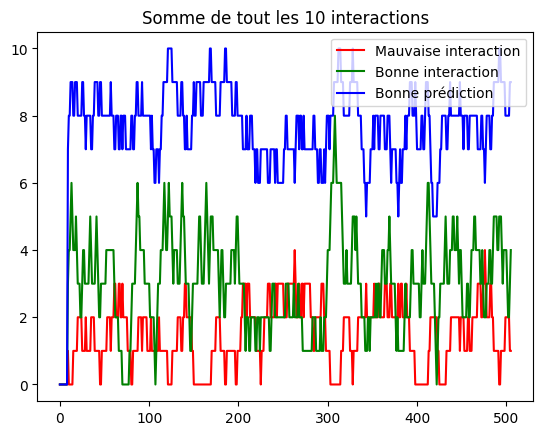

In [17]:
# Function to map integers to colors
def int_to_color(value):
    if value == 0:
        return "yellow"
    return "gray"

# Create a figure and axis
fig, ax = plt.subplots()

#1 / (len(by_10_bad_inter) -10)
for i, value in enumerate(agent.predictExplor):
    ax.add_patch(plt.Rectangle((i, -10), 0.1, 10, color=int_to_color(value), alpha=0.4))

# Plot the data
plt.plot(by_10_bad_inter, label='Mauvaise interaction', color='red')
plt.plot(by_10_good_inter, label='Bonne interaction', color='green')
plt.plot(pourcent_by_10, label='Bonne prédiction', color='blue')
plt.title('Somme de tout les 10 interactions')
plt.legend()
plt.show()
plt.savefig("tmp.pdf")
plt.close()
